# Crime

In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score

In [2]:
%config InlineBackend.figure_format = 'retina'

### Data Transformation

In [3]:
# Read in data
df = pd.read_csv('data/crime.csv')

# Extract LSOA code and crime type columns.
df = df[['LSOA code', 'Crime type']]

# List of different crime types included in data.
crimeTypes = ['Anti-social behaviour',
              'Violence and sexual offences',
              'Vehicle crime',
              'Other theft',
              'Burglary',
              'Theft from the person',
              'Criminal damage and arson',
              'Public order',
              'Shoplifting',
              'Drugs',
              'Robbery',
              'Bicycle theft',
              'Other crime',
              'Possession of weapons']

# Create dictionary with integers representing crimes.
crimeTypeDict = { y: x for x, y in enumerate(crimeTypes) }

# Dictionary containing column for replacement.
toReplace = { "Crime type":  crimeTypeDict }

# Replaces crime type strings with integers.
df.replace(toReplace, inplace=True)




# Replace duplicate codes with rows containing number of crimes commited.
myDict = {}

for i in df.values:
    
    if pd.isnull(i[0]):
        continue
    
    if i[0] in myDict:
        myDict[i[0]][i[1]] += 1
        
    else:
        myDict[i[0]] = [0] * 14

df = pd.DataFrame.from_dict(myDict, orient='index')

data = df.values

### Data Processing

In [4]:
def evaluateClustering(data, k, method='kmeans'):
    '''
    Uses multiple values of k to cluster data using either k-means or GMM
    algorithms, results are then displayed on a graph with corresponding
    Davies-Bouldin scores. The parameter for method is either 'kmeans' or
    'gmm'.
    '''
    
    domain = np.arange(2, k+1)
    results = []
    
    # Obtain results.
    for i in domain:
            
        # Cluster the data with i clusters with certain method.
        if method == 'kmeans':
            labels = KMeans(n_clusters=i, random_state=10).fit(data).labels_
            
        if method == 'gmm':
            gmm = GaussianMixture(n_components=i, random_state=20).fit(data)
            labels = gmm.predict(data)

        # Test accuracy
        results.append(davies_bouldin_score(data, labels))
    
    # Draw graph to show results.
    plt.ylabel('Davies-Bouldin Values')
    plt.xlabel('Number of clusters (k)')
    plt.plot(domain, results)
    plt.show()
    
    # Print best results.
    print('Results')
    maximum = max(results)
    print('K:', results.index(maximum) + 2)
    print('Value:', maximum)

In [5]:
def evaluateDBSCAN(eps, epsInterval, minPts):
    '''
    Tests the DBSCAN algorithm on data using defined limits on eps
    and minPts, results are the Davies-Bouldin score plotted on a 3D
    graph. Parameters are maximum eps, the number of eps values to be
    tested and the maximnum number for minPts.
    '''

    # Generate domain for parameter values.
    epsDomain = np.linspace(1, eps, epsInterval)
    minPtsDomain = np.arange(2, minPts + 1)

    # Calculate DBI for grid of eps and minPts values.
    results = []
    for i in epsDomain:
        for j in minPtsDomain:

            labels = DBSCAN(i, j).fit_predict(data)
            score = davies_bouldin_score(data, labels)
            results.append((i, j, score))
    
    # Convery to numpy array.
    results = np.array(results)
    
    # Reshape arrays.
    lenX = epsDomain.size
    lenY = minPtsDomain.size
    x = np.reshape(results[:,0], (lenX, lenY))
    y = np.reshape(results[:,1], (lenX, lenY))
    z = np.reshape(results[:,2], (lenX, lenY))
    
    # Draw results.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='Blues')
    ax.set_xlabel('eps')
    ax.set_ylabel('minPts')
    ax.set_zlabel('DBI')
    ax.dist = 11
    plt.show()
    
    # Print results.
    ind =  np.where(results[:,2] == np.amax(results[:,2]))[0][0]
    print('Results')
    print('eps:', results[:,0][ind])
    print('minPts:', results[:,1][ind])
    print('Value:', results[:,2][ind])

#### K-Means

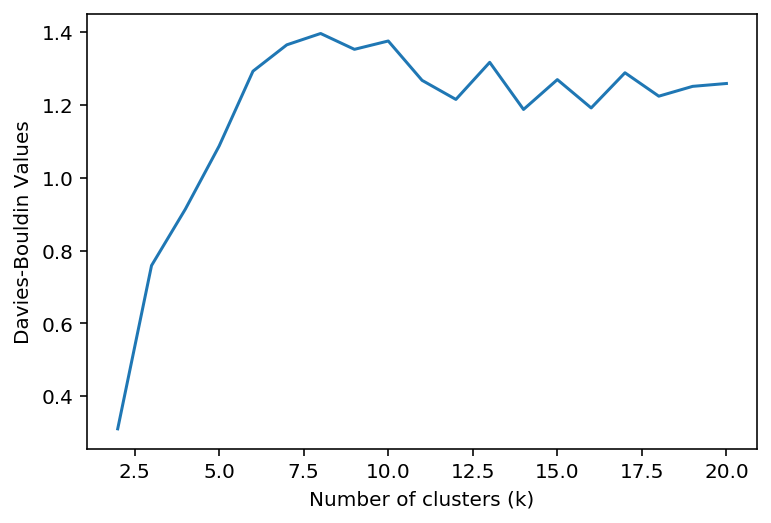

Results
K: 8
Value: 1.3962970936870565


In [6]:
evaluateClustering(data, 20, 'kmeans')

#### GMM Model

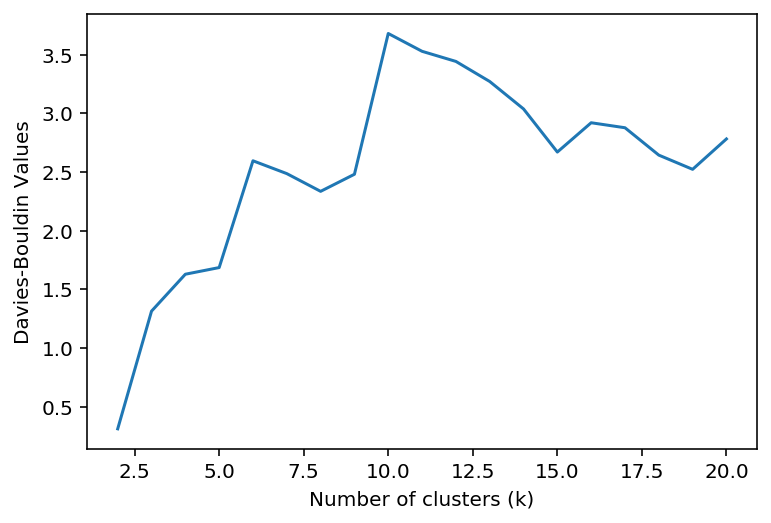

Results
K: 10
Value: 3.6793766972024877


In [7]:
evaluateClustering(data, 20, 'gmm')

#### DBSCAN Model

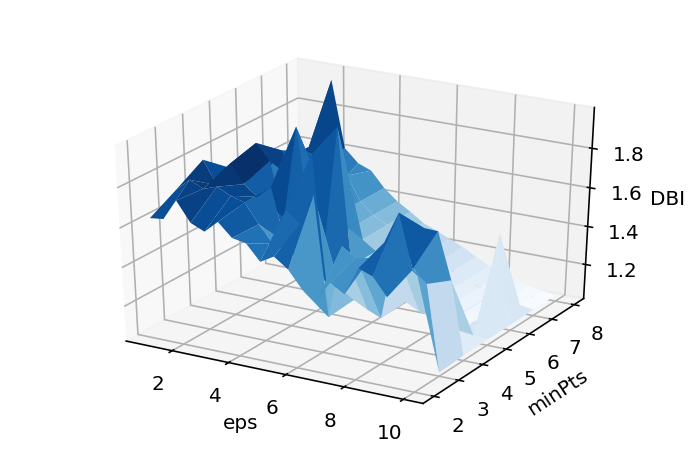

Results
eps: 4.789473684210526
minPts: 5.0
Value: 1.9830429549473914


In [8]:
evaluateDBSCAN(10, 20, 8)

### Interperate Clusters

In [9]:
def process(data):
    '''
    Computes clusters using GMM algorihtm.
    '''
    
    gmm = GaussianMixture(n_components=10, random_state=20).fit(data)
    labels = gmm.predict(data)
    
    clusters = [data[labels == i] for i in np.unique(labels)]
    k = len(clusters)
    sizes = [len(x) for x in clusters]
    averages = [np.mean(np.mean(i, axis=1)) for i in clusters]
    
    return clusters, k, sizes, averages


def sizeGraph(k, sizes):
    '''
    Plot bar chart showing number of LSOAs in each cluster.
    '''
    
    plt.title('Cluster Size')
    plt.xlabel('Cluster number')
    plt.ylabel('Size')
    plt.bar(range(k), sizes)
    plt.xticks(range(k))
    plt.show()

    print('Size of clusters.')
    for i in range(k):
        print(i, ':', sizes[i])
        
        
def averageGraph(k, averages):
    '''
    Plot bar chart showing average number of total crimes commited in LSOAs in each cluster.
    '''

    plt.xlabel('Cluster number')
    plt.ylabel('Average number of crime commited')
    plt.bar(range(k), averages, align='center')
    plt.xticks(range(k))
    plt.show()

    print('Average crimes of clusters.')
    for i in range(k):
        print(i, ':', round(averages[i], 2))
    
    
def plotMean(k, clusters):
    '''
    Plot graph for each cluster showing the average number of specific cries commited.
    '''

    for i in range(k):

        result = np.mean(clusters[i], axis=0)

        plt.title('Cluster: ' + str(i))
        plt.bar(range(len(result)), result)
        plt.ylabel('Average number of crimes')
        plt.xlabel('Crime type')
        plt.xticks(range(len(result)))
        plt.show()

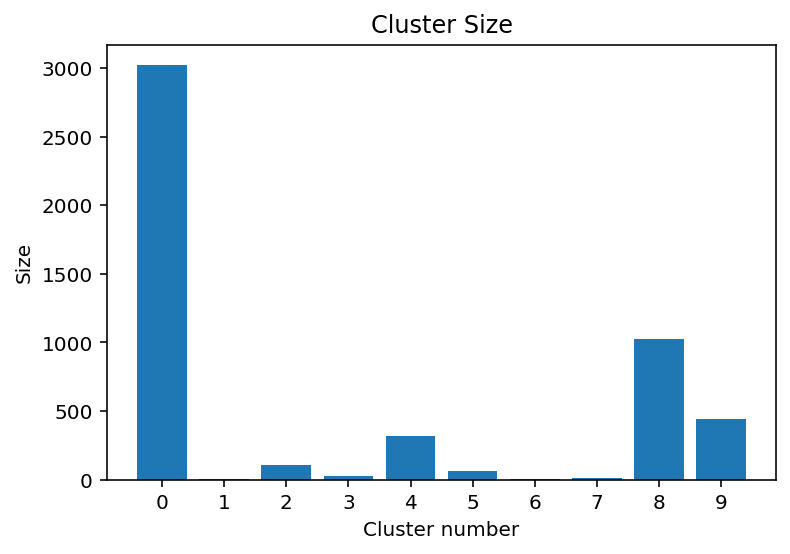

Size of clusters.
0 : 3020
1 : 3
2 : 108
3 : 24
4 : 315
5 : 61
6 : 1
7 : 11
8 : 1022
9 : 441


In [10]:
# Cluster data and get label results
clusters, k, sizes, averages = process(data)
sizeGraph(k, sizes)

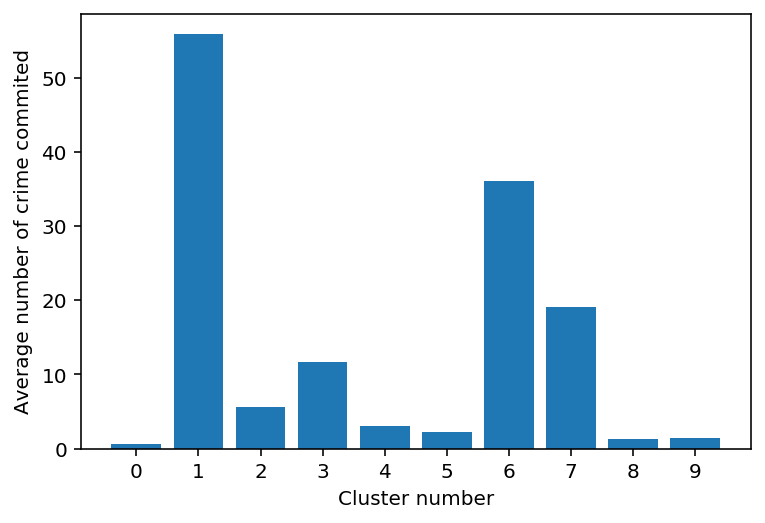

Average crimes of clusters.
0 : 0.68
1 : 55.81
2 : 5.54
3 : 11.65
4 : 3.01
5 : 2.22
6 : 36.0
7 : 19.13
8 : 1.34
9 : 1.45


In [11]:
averageGraph(k, averages)

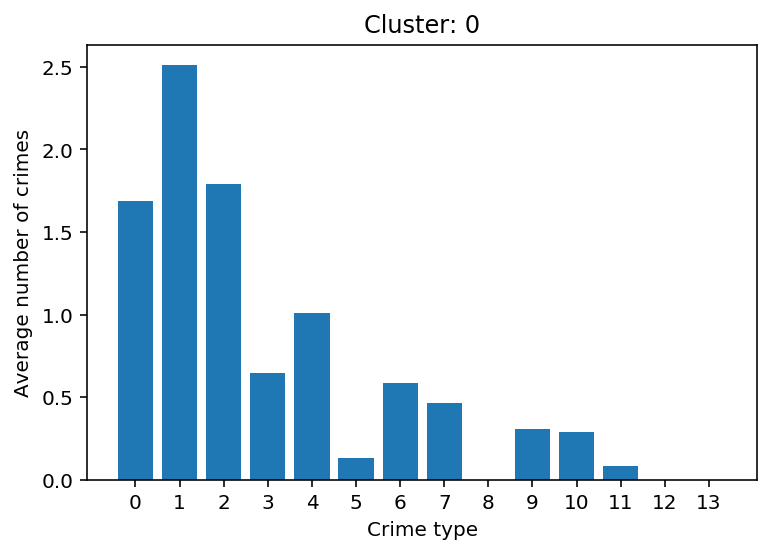

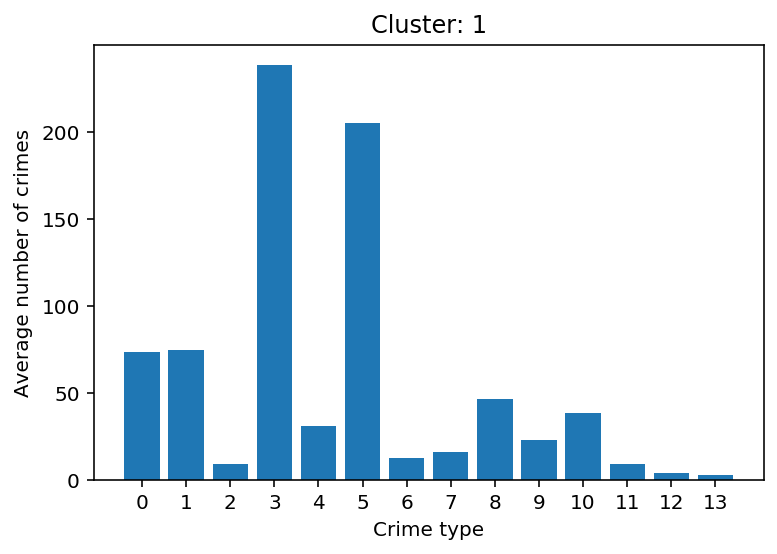

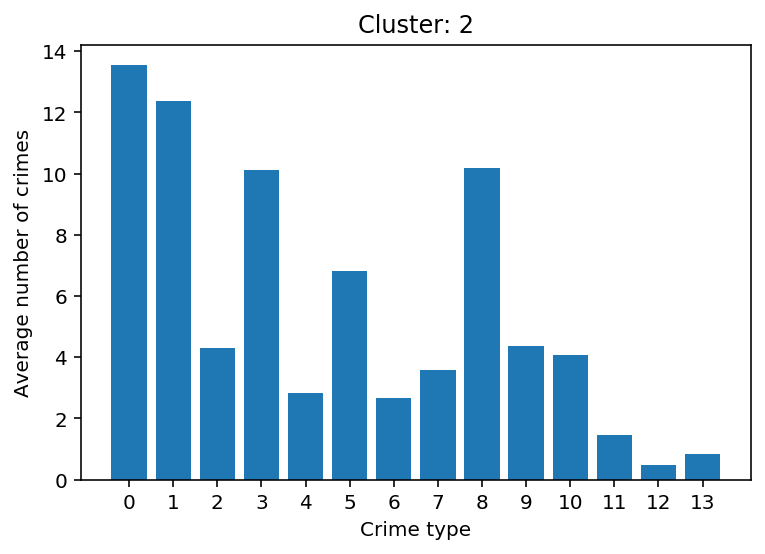

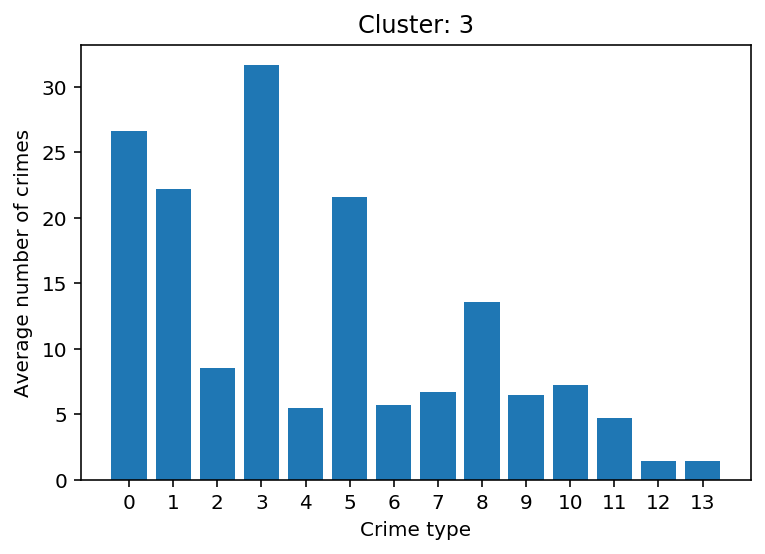

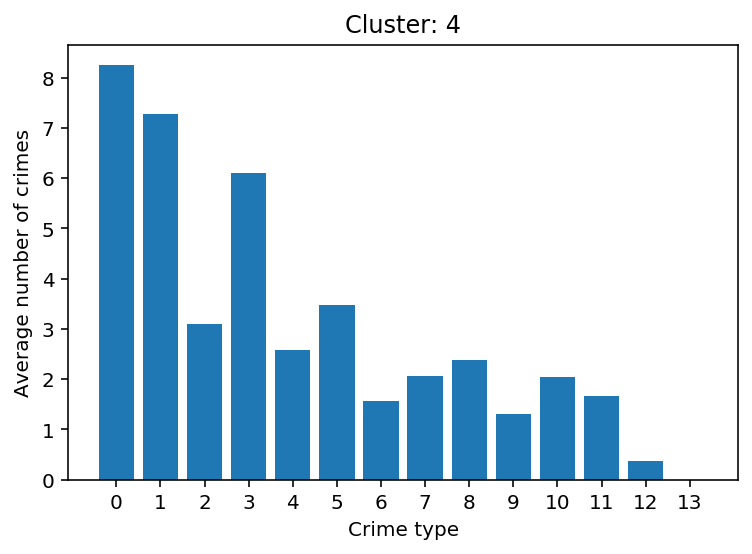

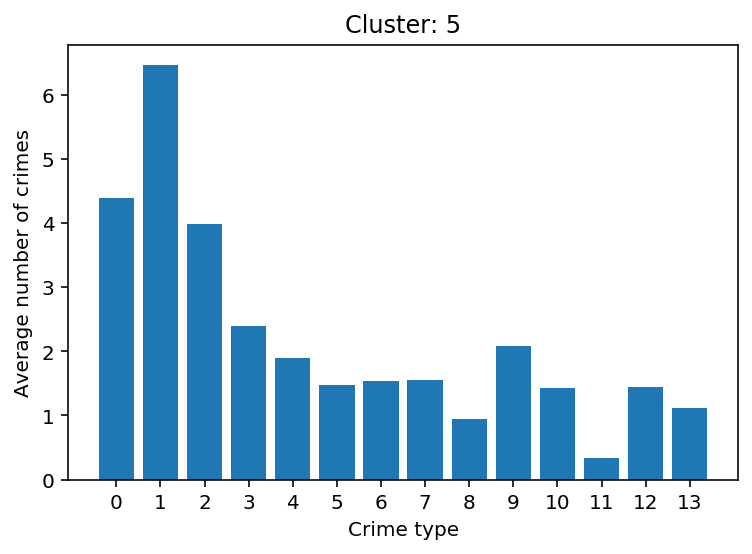

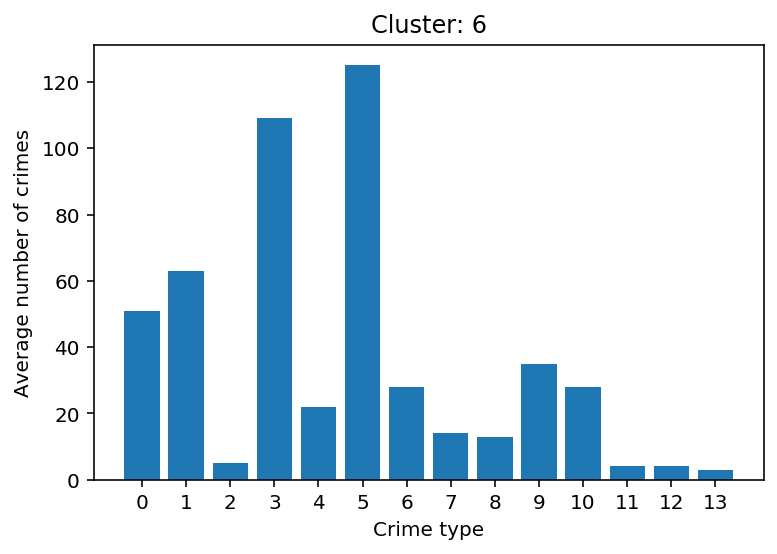

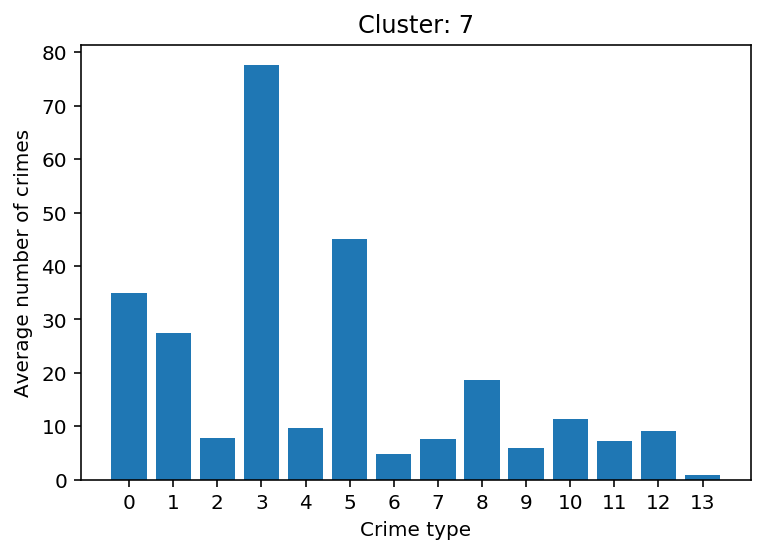

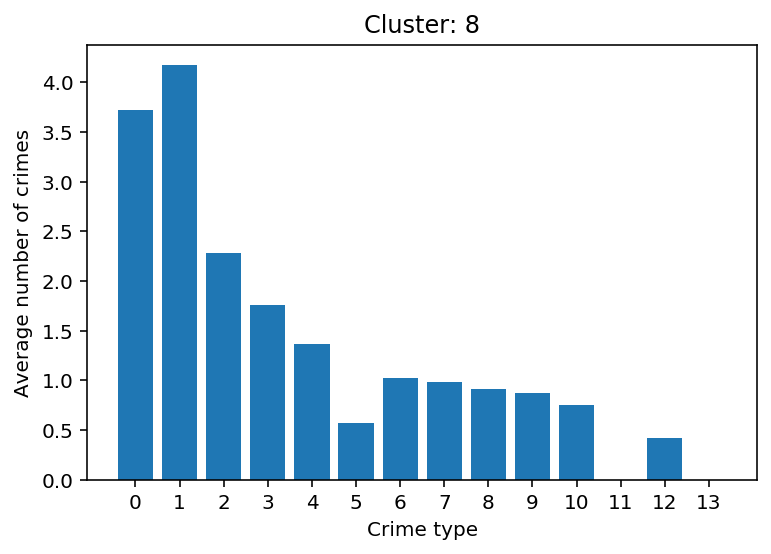

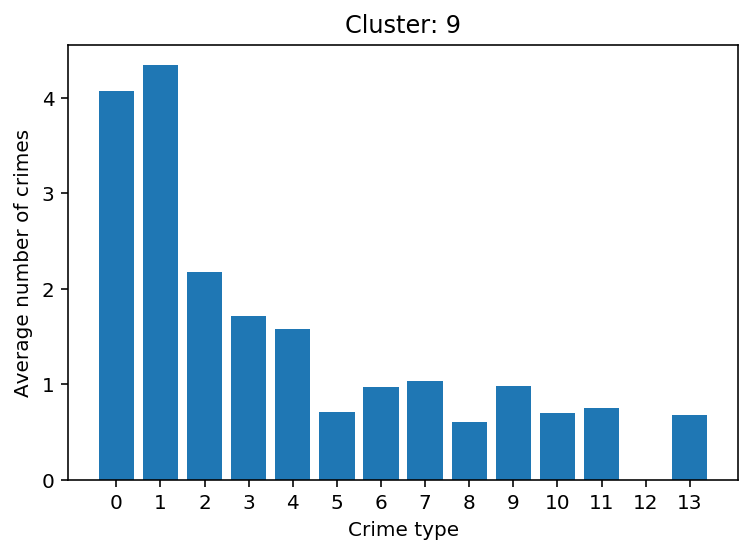

In [12]:
plotMean(k, clusters)